In [38]:
from google.colab import drive 
drive.mount('/gdrive') # 구글드라이브 연결

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [39]:
import zipfile as zf
files = zf.ZipFile("/gdrive/My Drive/Colab Notebooks/onlyimagedata.zip",'r') # 압축 파일의 자료 읽기
files.extractall()
files.close()

In [40]:
# 폴더명 기준으로 라벨 구분
import os

labels = os.listdir(r'/content/data') 
print('라벨:', labels)

라벨: ['plastic', 'pet', 'vin', 'styro', 'paper', 'can']


In [41]:
# 각 라벨마다 train, val 파일 생성 및 데이터 나누기(8대2)
!pip install split-folders

import splitfolders

os.mkdir("/content/data_new")
splitfolders.ratio('/content/data', output="/content/data_new", seed=77, ratio=(0.8, 0.2))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


FileExistsError: ignored

In [46]:
!pip install torch
!pip install torchvision

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os
import copy
import numpy as np
import time
from torchsummary import summary

cudnn.benchmark = True # 최적의 backend 연산을 찾는 flag를 true 로 설정
plt.ion()   # 대화형 모드

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # GPU 사용가능 여부 확인. cuda가 설정되어 있으면 연산을 gpu로 하고, 아니면 cpu
device

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


device(type='cuda', index=0)

In [47]:
# 데이터셋을 불러올 때 사용할 변형(transformation) 객체를 train, val 별로 지정
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),# 이미지 resize 
        transforms.RandomResizedCrop(224), # 이미지를 랜덤으로 자르기
        transforms.RandomHorizontalFlip(),# 데이터 증진(augmentation)
        transforms.ToTensor(), # 데이터를 tensor로 바꿔준다. 넘파이는 정수값이 들어있어 오차율 가늠이 힘들고 CIDA 연산도 지원하지 않음
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # 정규화(normalization)작업에 쓰일 각 채널의 표준값과 표준편차값, PyTorch 기본값으로 셋팅
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [48]:
data_dir = '/content/data_new' # 이미지 데이터셋에 상단의 transform 내용 적용

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,shuffle=True, num_workers=4) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

In [49]:
# train과 valid 데이터 개수 확인
print(len(image_datasets['train']), len(image_datasets['val']))

48000 12000


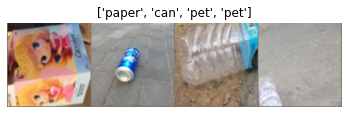

In [50]:
# 데이터 이미지 출력하는 함수 만들기
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0)) # torch.Tensor를 numpy 객체로 변환    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    plt.axis('off')  # 바깥선 지우기
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)    # 이미지 출력
    plt.title(title)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs) # 배치로부터 격자 형태의 이미지 생성
    imshow(out, title=[class_names[x] for x in classes]) #  배치사이즈만큼 image, label이 출력

inputs, classes = next(iter(dataloaders['train'])) # 학습 데이터의 배치를 얻기
show_databatch(inputs, classes) # 학습데이터 이미지 출력

In [51]:
def visualize_model(model, num_images=6): # 시각화 함수
    was_training = vgg16.training
    vgg16.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = vgg16(inputs)  # 모델에 나온 값
            _, preds = torch.max(outputs, 1) # 예측값

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}') #예측값만 출력
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    vgg16.train(mode=was_training) # 앞에서 선언한 값에 넣기
                    return
        vgg16.train(mode=was_training)

In [52]:
def train_model(model, optimizer, num_epochs=25): # 모델학습 함수
    since = time.time()

    loss_history = {'train': [], 'val': []}
    metric_history = {'train': [], 'val': []}

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):  # 에폭마다 for문을 넣어주고
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # 각 에폭(epoch)은 학습단계와 테스트 단계를 거쳐서 진행
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
            else:
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 반복
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()

                # 순전파
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs) # 아웃풋 설정
                    _, preds = torch.max(outputs, 1) # 인풋에 대현 예측값
                    loss = criterion(outputs, labels) # 예측값과 실제 결과값 비교

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward() # 역전파
                        optimizer.step() # 최적화(optimizer 스텝 증가) 

                # 통계
                running_loss += loss.item() * inputs.size(0) # 교차엔트로피 계산. deafualt값이 mean이므로 각 데이터 마다의 손실 평균이 저장, 배치 사이즈를 곱해줘 한 배치 사이즈의 loss 총합을 계산
                running_corrects += torch.sum(preds == labels.data) # 예측값이 맞은 횟수 더하기
            if phase == 'train':
                exp_lr_scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase] # 에폭에 따른 loss, accuracy 계산 (전체 데이터 loss합/ 각 데이터셋 크기)
            epoch_acc = running_corrects.double() / dataset_sizes[phase] 

            print(f'{phase} Loss: {epoch_loss:.4f} Accuracy: {epoch_acc:.4f}') # loss, accuracy 출력

            if phase == 'train':
                loss_history['train'].append(epoch_loss)
                metric_history['train'].append(epoch_acc)
            else:
                loss_history['val'].append(epoch_loss)
                metric_history['val'].append(epoch_acc)

            # 모델을 깊은 복사(deep copy)함
            if phase == 'val' and epoch_acc > best_acc: # best_acc, weight 값 저장
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since       # 반복할 때마다 현재 - 기존 시간 계산해 걸린 시간 표시
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Accuracy: {best_acc:4f}')

    # 제일 잘 나온 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history

In [53]:
vgg16 = models.vgg16(pretrained=True)
num_ftrs = vgg16.classifier[6].in_features
vgg16.classifier[6] = nn.Linear(num_ftrs, len(class_names))

vgg16.to(device)

criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [54]:
from torchsummary import summary
summary(vgg16, (3,32,32)) # 모델 정보 확인

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

In [ ]:
vgg16, loss_hist, metric_hist = train_model(vgg16, optimizer_ft, num_epochs=10) # 학습을 수행

Epoch 0/9
----------
train Loss: 0.6555 Accuracy: 0.7656
val Loss: 0.3846 Accuracy: 0.8722

Epoch 1/9
----------
train Loss: 0.4729 Accuracy: 0.8329
val Loss: 0.3120 Accuracy: 0.8919

Epoch 2/9
----------
train Loss: 0.4135 Accuracy: 0.8530
val Loss: 0.2794 Accuracy: 0.9069

Epoch 3/9
----------
train Loss: 0.3812 Accuracy: 0.8645
val Loss: 0.3281 Accuracy: 0.8885

Epoch 4/9
----------
train Loss: 0.3556 Accuracy: 0.8738
val Loss: 0.2911 Accuracy: 0.9061

Epoch 5/9
----------
train Loss: 0.3388 Accuracy: 0.8789
val Loss: 0.2483 Accuracy: 0.9128

Epoch 6/9
----------
train Loss: 0.3212 Accuracy: 0.8860
val Loss: 0.2131 Accuracy: 0.9294

Epoch 7/9
----------


In [ ]:
visualize_model(vgg16) # 예측값 시각화 

In [ ]:
train_loss_history = loss_hist["train"]
val_loss_history = loss_hist["val"]
train_acc_history = metric_hist["train"]
val_acc_history = metric_hist["val"]

In [ ]:
plt.title("Train-Val Loss")
plt.plot(train_loss_history ,label="train")
plt.plot(val_loss_history,label="val")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(train_acc_history,label="train")
plt.plot(val_acc_history,label="val")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [ ]:
vgg16_conv = torchvision.models.vgg16(pretrained=True)
for param in vgg16_conv.parameters():
    param.requires_grad = False
    
num_ftrs = vgg16_conv.classifier[6].in_features
vgg16_conv.classifier[6] = nn.Linear(num_ftrs, len(class_names))

vgg16_conv.to(device)

criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_conv = optim.SGD(vgg16_conv.fc.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv, loss_hist, metric_hist = train_model(vgg16_conv, optimizer_conv, num_epochs=10) # 학습을 수행

In [ ]:
train_loss_history = loss_hist["train"]
val_loss_history = loss_hist["val"]
train_acc_history = metric_hist["train"]
val_acc_history = metric_hist["val"]

In [ ]:
plt.title("Train-Val Loss")
plt.plot(train_loss_history ,label="train")
plt.plot(val_loss_history,label="val")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(train_acc_history,label="train")
plt.plot(val_acc_history,label="val")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()